<a href="https://colab.research.google.com/github/jayd-bit/BooleanAutocrats/blob/master/PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# --------------------------
# 1. Generate Synthetic Data
# --------------------------

# Import required libraries
import numpy as np
import torch

# Physics parameters
g = 9.8        # acceleration due to gravity
h0 = 1.0       # initial height
v0 = 10.0      # initial velocity

# True (analytical) solution h(t) = h0 + v0*t - 0.5*g*t^2
def true_solution(t):
    return h0 + v0*t - 0.5*g*(t**2)

# Generate some time points
t_min, t_max = 0.0, 2.0
N_data = 10
t_data = np.linspace(t_min, t_max, N_data)

# Generate synthetic "experimental" heights with noise
np.random.seed(0)
noise_level = 0.7
h_data_exact = true_solution(t_data)
h_data_noisy = h_data_exact + noise_level*np.random.randn(N_data)

# Convert to PyTorch tensors
t_data_tensor = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)
h_data_tensor = torch.tensor(h_data_noisy, dtype=torch.float32).view(-1, 1)

print("t_data_tensor shape:", t_data_tensor.shape)
print("h_data_tensor shape:", h_data_tensor.shape)


t_data_tensor shape: torch.Size([10, 1])
h_data_tensor shape: torch.Size([10, 1])


In [ ]:
# --------------------------------------------------------
# 2. Define a small feed-forward neural network for h(t)
# --------------------------------------------------------

# Import torch.nn
import torch
import torch.nn as nn

class PINN(nn.Module):
    def __init__(self, n_hidden=20):
        super(PINN, self).__init__()
        # A simple MLP with 2 hidden layers
        self.net = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, t):
        """
        Forward pass: input shape (batch_size, 1) -> output shape (batch_size, 1)
        """
        return self.net(t)

# Instantiate the model
model = PINN(n_hidden=20)

# Quick test
t_test = torch.tensor([[0.0], [1.0], [2.0]])
print("Predicted h(t):", model(t_test))


Predicted h(t): tensor([[0.1050],
        [0.2262],
        [0.3204]], grad_fn=<AddmmBackward0>)


In [ ]:
# --------------------------------
# 3. Helper for Automatic Diff
# --------------------------------
def derivative(y, x):
    """
    Computes dy/dx using PyTorch's autograd.
    y and x must be tensors with requires_grad=True for x.
    """
    return torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

In [ ]:
# ----------------------------------------
# 4. Define the Loss Components (PINN)
# ----------------------------------------

# We have:
#    (1) Data loss (fit noisy data)
#    (2) ODE loss: dh/dt = v0 - g * t
#    (3) Initial condition loss: h(0) = h0

def physics_loss(model, t):
    """
    Compare d(h_pred)/dt with the known expression (v0 - g t).
    """
    # t must have requires_grad = True for autograd to work
    t.requires_grad_(True)

    h_pred = model(t)
    dh_dt_pred = derivative(h_pred, t)

    # For each t, physics says dh/dt = v0 - g * t
    dh_dt_true = v0 - g * t

    loss_ode = torch.mean((dh_dt_pred - dh_dt_true)**2)
    return loss_ode

def initial_condition_loss(model):
    """
    Enforce h(0) = h0.
    """
    # Evaluate at t=0
    t0 = torch.zeros(1, 1, dtype=torch.float32, requires_grad=False)
    h0_pred = model(t0)
    return (h0_pred - h0).pow(2).mean()

def data_loss(model, t_data, h_data):
    """
    MSE between predicted h(t_i) and noisy measurements h_data.
    """
    h_pred = model(t_data)
    return torch.mean((h_pred - h_data)**2)

In [ ]:
# ---------------------------------------
# 5. Training Setup
# ---------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Hyperparameters for weighting the loss terms
lambda_data = 2.0
lambda_ode  = 20.0
lambda_ic   = 20.0

# For logging
num_epochs = 4000
print_every = 200

In [ ]:
# ---------------------------------------
# 6. Training Loop
# ---------------------------------------

model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Compute losses
    l_data = data_loss(model, t_data_tensor, h_data_tensor)
    l_ode  = physics_loss(model, t_data_tensor)
    l_ic   = initial_condition_loss(model)

    # Combined loss
    loss = lambda_data * l_data + lambda_ode * l_ode + lambda_ic * l_ic

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % print_every == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Total Loss = {loss.item():.6f}, "
              f"Data Loss = {l_data.item():.6f}, "
              f"ODE Loss = {l_ode.item():.6f}, "
              f"IC Loss = {l_ic.item():.6f}")


Epoch 200/4000, Total Loss = 1.310937, Data Loss = 0.621585, ODE Loss = 0.001920, IC Loss = 0.001468
Epoch 400/4000, Total Loss = 1.292130, Data Loss = 0.615743, ODE Loss = 0.001632, IC Loss = 0.001401
Epoch 600/4000, Total Loss = 1.271312, Data Loss = 0.608945, ODE Loss = 0.001368, IC Loss = 0.001303
Epoch 800/4000, Total Loss = 1.245379, Data Loss = 0.599184, ODE Loss = 0.001182, IC Loss = 0.001169
Epoch 1000/4000, Total Loss = 1.206729, Data Loss = 0.584342, ODE Loss = 0.000949, IC Loss = 0.000954
Epoch 1200/4000, Total Loss = 1.153247, Data Loss = 0.564535, ODE Loss = 0.000578, IC Loss = 0.000630
Epoch 1400/4000, Total Loss = 1.113640, Data Loss = 0.550273, ODE Loss = 0.000330, IC Loss = 0.000325
Epoch 1600/4000, Total Loss = 1.104237, Data Loss = 0.546889, ODE Loss = 0.000329, IC Loss = 0.000194
Epoch 1800/4000, Total Loss = 1.102661, Data Loss = 0.546220, ODE Loss = 0.000345, IC Loss = 0.000166
Epoch 2000/4000, Total Loss = 1.101609, Data Loss = 0.545586, ODE Loss = 0.000353, IC 

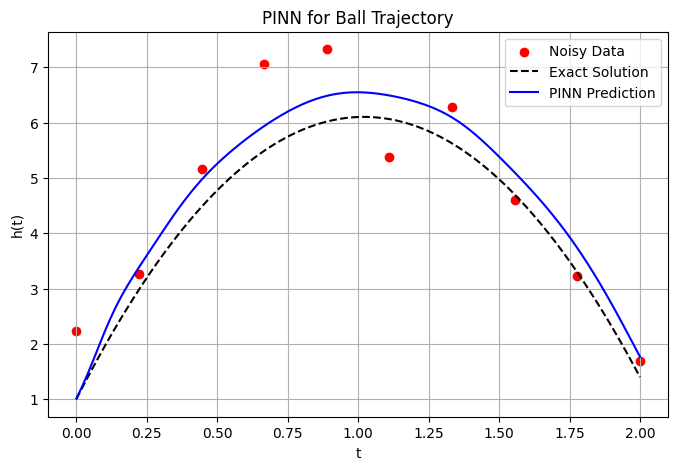

In [ ]:
# ---------------------------------------
# 7. Evaluate the Trained Model
# ---------------------------------------
model.eval()
t_plot = np.linspace(t_min, t_max, 100).reshape(-1, 1).astype(np.float32)
t_plot_tensor = torch.tensor(t_plot, requires_grad=True)
h_pred_plot = model(t_plot_tensor).detach().numpy()

# True solution (for comparison)
h_true_plot = true_solution(t_plot)

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(t_data, h_data_noisy, color='red', label='Noisy Data')
plt.plot(t_plot, h_true_plot, 'k--', label='Exact Solution')
plt.plot(t_plot, h_pred_plot, 'b', label='PINN Prediction')
plt.xlabel('t')
plt.ylabel('h(t)')
plt.legend()
plt.title('PINN for Ball Trajectory')
plt.grid(True)
plt.show()